In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np


In [2]:
file_path="/Users/snip/Documents/MEOP/Diameter runs for fitting/1_5625_trial.xlsx"
df= pd.read_excel(file_path)
name=file_path.split("/")
name[-1]=name[-1].replace("_trial.xlsx","")

diameter=float(name[-1].replace("_","."))
print(diameter)
df.drop(columns=["Time - Voltage (Formula Result)","Polarization (%) - Voltage (Formula Result)"], inplace=True)
df.rename(columns={"Time - Voltage (Formula Result).1":"time","Polarization (%) - Voltage (Formula Result).1":"polarization"}, inplace=True)


1.5625


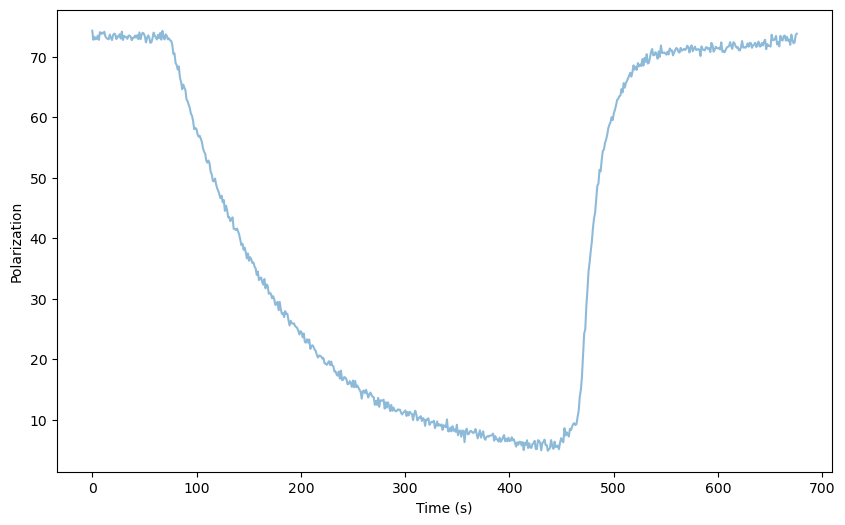

,time,polarization
0,0.000,74.3014
1,1.048,72.8020
2,2.101,73.3025
3,3.149,72.8840
4,4.201,72.9517
...,...,...
639,671.341,72.7743
640,672.391,72.2355
641,673.435,72.3949
642,674.480,73.5830


In [3]:
# Convert time string to seconds
# Handle both "MM:SS" and "HH:MM:SS" formats
def time_to_seconds(time_str):
    parts = str(time_str).split(':')
    if len(parts) == 2:  # MM:SS format
        return int(parts[0]) * 60 + float(parts[1])
    elif len(parts) == 3:  # HH:MM:SS format
        return int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])
    else:
        return float(time_str)  # Already in seconds

df["time"] = df["time"].apply(time_to_seconds)

#rescale time to start from zero
df["time"] = df["time"] - df["time"].min()

plt.figure(figsize=(10,6))
plt.plot(df["time"], df["polarization"], label="Raw Data", alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Polarization")
plt.show()
df

In [4]:

df["smoothed"] = savgol_filter(df["polarization"], 60, 3)

# Find where the decay/fall starts by detecting negative derivative
df["derivative"] = np.gradient(df["smoothed"])

# global max
global_max_index = df["smoothed"].idxmax()

# Look for where decay consistently starts (derivative becomes negative after max)
decay_start_index = global_max_index
for i in range(global_max_index, len(df)):
    # Check if derivative stays negative for next few points (confirms decay started)
    if i + 5 < len(df):
        if all(df["derivative"].iloc[i:i+5] < 0):
            decay_start_index = i
            break

# Find the actual maximum just before decay starts
max_index = df.loc[:decay_start_index, "smoothed"].idxmax()
max_pol = df["smoothed"][max_index]
min_index = df["smoothed"].idxmin()
min_pol = df["smoothed"][min_index]

target_value = max_pol / np.e 
relaxation_data = df.iloc[max_index:min_index+1]
relaxation_data = relaxation_data[relaxation_data["smoothed"] > target_value]
max_time = df["time"][max_index]
relaxation_time = relaxation_data["time"].iloc[-1] - max_time

print(f"Global max index: {global_max_index}, Decay start index: {decay_start_index}, Selected max index: {max_index}")
print(f"Max polarization (before decay): {max_pol:.2f}%")
print(f"Relaxation time: {relaxation_time:.3f} seconds")


Global max index: 53, Decay start index: 53, Selected max index: 53
Max polarization (before decay): 73.77%
Relaxation time: 129.314 seconds


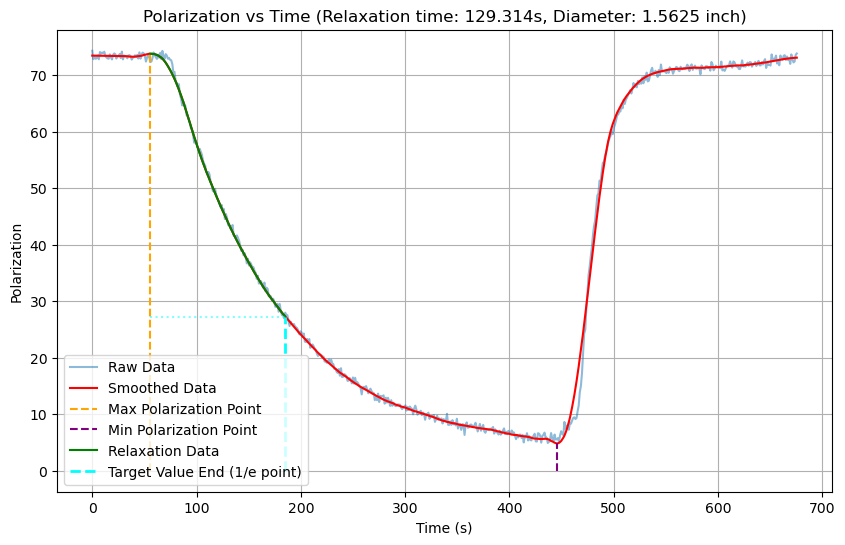

<Figure size 640x480 with 0 Axes>

In [5]:
plt.figure(figsize=(10,6))
plt.plot(df["time"], df["polarization"], label="Raw Data", alpha=0.5)
plt.plot(df["time"], df["smoothed"], label="Smoothed Data", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Polarization")
plt.vlines(df["time"][max_index], ymin=0, ymax=max_pol, colors='orange', linestyles='--', label='Max Polarization Point')
plt.vlines(df["time"][min_index], ymin=0, ymax=min_pol, colors='purple', linestyles='--', label='Min Polarization Point')
plt.title("Polarization vs Time with Smoothing")
plt.legend()
plt.plot(relaxation_data["time"], relaxation_data["smoothed"], label="Relaxation Data", color='green')

# Add vertical line where target value ends (relaxation time point)
target_end_time = relaxation_data["time"].iloc[-1]
plt.vlines(target_end_time, ymin=0, ymax=target_value, colors='cyan', linestyles='--', label='Target Value End (1/e point)', linewidth=2)
plt.hlines(target_value, xmin=df["time"][max_index], xmax=target_end_time, colors='cyan', linestyles=':', alpha=0.5)

plt.xlabel("Time (s)")
plt.ylabel("Polarization")      
plt.title(f"Polarization vs Time (Relaxation time: {np.round(relaxation_time, 3)}s, Diameter: {diameter} inch)")
plt.legend()
plt.grid()
plt.show()
plt.savefig("/Users/snip/Documents/MEOP/relaxation_time_plot.png", dpi=300)

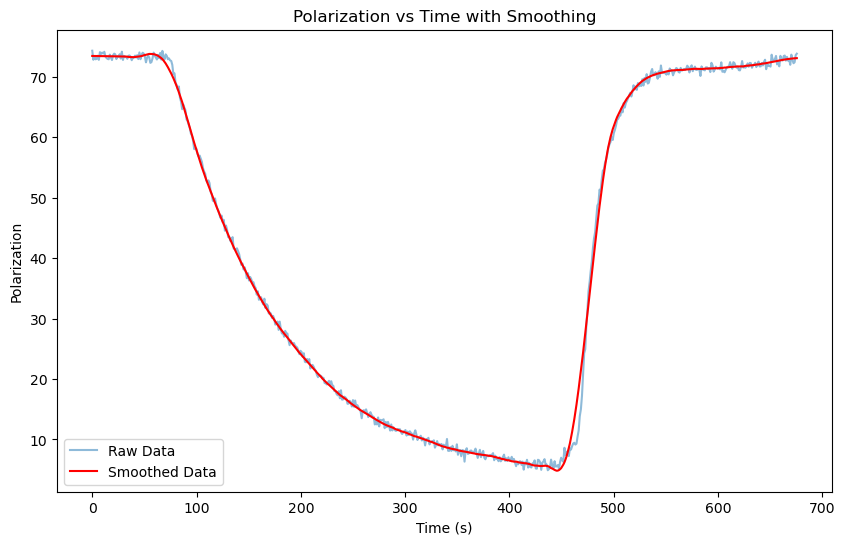

In [6]:
plt.figure(figsize=(10,6))
plt.plot(df["time"], df["polarization"], label="Raw Data", alpha=0.5)
plt.plot(df["time"], df["smoothed"], label="Smoothed Data", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Polarization")
plt.title("Polarization vs Time with Smoothing")
plt.legend()
plt.show()

In [ ]:
import os
from pathlib import Path

# Directory containing all the Excel files
data_dir = "/Users/snip/Documents/MEOP/Diameter runs for fitting"
output_dir = "/Users/snip/Documents/MEOP/relaxation_plots"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get all Excel files in the directory
excel_files = list(Path(data_dir).glob("*.xlsx"))
print(f"Found {len(excel_files)} Excel files to process\n")

# Process each file
results = []
for file_path in excel_files:
    try:
        print(f"Processing: {file_path.name}")
        
        # Read the data
        df = pd.read_excel(str(file_path))
        
        # Extract diameter from filename
        name_parts = file_path.stem.split("_")
        diameter = float(file_path.stem.replace("_trial", "").replace("_", "."))
        
        # Drop and rename columns
        df.drop(columns=["Time - Voltage (Formula Result)", "Polarization (%) - Voltage (Formula Result)"], inplace=True)
        df.rename(columns={"Time - Voltage (Formula Result).1": "time", 
                          "Polarization (%) - Voltage (Formula Result).1": "polarization"}, inplace=True)
        
        # Convert time to seconds
        def time_to_seconds(time_str):
            parts = str(time_str).split(':')
            if len(parts) == 2:
                return int(parts[0]) * 60 + float(parts[1])
            elif len(parts) == 3:
                return int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])
            else:
                return float(time_str)
        
        df["time"] = df["time"].apply(time_to_seconds)
        df["time"] = df["time"] - df["time"].min()  # Start from zero
        
        # Apply smoothing
        df["smoothed"] = savgol_filter(df["polarization"], 60, 3)
        df["derivative"] = np.gradient(df["smoothed"])
        
        # Find max and decay start
        global_max_index = df["smoothed"].idxmax()
        decay_start_index = global_max_index
        for i in range(global_max_index, len(df)):
            if i + 5 < len(df):
                if all(df["derivative"].iloc[i:i+5] < 0):
                    decay_start_index = i
                    break
        
        max_index = df.loc[:decay_start_index, "smoothed"].idxmax()
        max_pol = df["smoothed"][max_index]
        min_index = df["smoothed"].idxmin()
        min_pol = df["smoothed"][min_index]
        
        # Calculate relaxation time
        target_value = max_pol / np.e
        relaxation_data = df.iloc[max_index:min_index+1]
        relaxation_data = relaxation_data[relaxation_data["smoothed"] > target_value]
        max_time = df["time"][max_index]
        
        # Check if we have valid relaxation data
        if len(relaxation_data) == 0:
            print(f"  ⚠ Warning: No data points above target value (1/e point)")
            print(f"  Using full decay range for analysis")
            relaxation_data = df.iloc[max_index:min_index+1]
            if len(relaxation_data) < 2:
                raise ValueError("Insufficient data points for relaxation analysis")
        
        relaxation_time = relaxation_data["time"].iloc[-1] - max_time
        
        # Store results
        results.append({
            "filename": file_path.name,
            "diameter": diameter,
            "relaxation_time": relaxation_time,
            "max_pol": max_pol
        })
        
        # Create and save plot
        plt.figure(figsize=(12, 7))
        plt.plot(df["time"], df["polarization"], label="Raw Data", alpha=0.5)
        plt.plot(df["time"], df["smoothed"], label="Smoothed Data", color='red', linewidth=2)
        
        # Only plot relaxation data if we have valid points above target
        if len(relaxation_data[relaxation_data["smoothed"] > target_value]) > 0:
            plt.plot(relaxation_data["time"], relaxation_data["smoothed"], label="Relaxation Data", color='green', linewidth=2)
        
        # Add vertical lines
        plt.vlines(df["time"][max_index], ymin=0, ymax=max_pol, colors='orange', linestyles='--', 
                  label='Max Polarization Point', linewidth=2)
        target_end_time = relaxation_data["time"].iloc[-1]
        plt.vlines(target_end_time, ymin=0, ymax=target_value, colors='cyan', linestyles='--', 
                  label='Target Value End (1/e point)', linewidth=2)
        plt.hlines(target_value, xmin=df["time"][max_index], xmax=target_end_time, 
                  colors='cyan', linestyles=':', alpha=0.5)
        
        plt.xlabel("Time (s)", fontsize=12)
        plt.ylabel("Polarization (%)", fontsize=12)
        plt.title(f"Relaxation Time Analysis\nDiameter: {diameter} inch | τ = {relaxation_time:.3f}s", fontsize=14)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        
        # Save with original filename
        output_filename = file_path.stem + "_relaxation.png"
        output_path = os.path.join(output_dir, output_filename)
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"  ✓ Diameter: {diameter} inch | Relaxation time: {relaxation_time:.3f}s")
        print(f"  ✓ Saved: {output_filename}\n")
        
    except Exception as e:
        print(f"  ✗ Error processing {file_path.name}: {str(e)}\n")

# Summary
print(f"\n{'='*60}")
print(f"Processing complete!")
print(f"Processed {len(results)} files successfully")
print(f"Plots saved to: {output_dir}")
print(f"{'='*60}\n")

# Display summary table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('diameter')
print("\nSummary of Results:")
print(results_df.to_string(index=False))
results_df

Found 3 Excel files to process

Processing: 1_6875_trial.xlsx
  ⚠ Warning: No data points above target value (1/e point)
  Using full decay range for analysis
  ✗ Error processing 1_6875_trial.xlsx: Insufficient data points for relaxation analysis

Processing: 1_5625_trial.xlsx
  ✓ Diameter: 1.5625 inch | Relaxation time: 129.314s
  ✓ Saved: 1_5625_trial_relaxation.png

Processing: 1_625_trial.xlsx
  ⚠ Warning: No data points above target value (1/e point)
  Using full decay range for analysis
  ✗ Error processing 1_625_trial.xlsx: Insufficient data points for relaxation analysis


Processing complete!
Processed 1 files successfully
Plots saved to: /Users/snip/Documents/MEOP/relaxation_plots


Summary of Results:
         filename  diameter  relaxation_time   max_pol
1_5625_trial.xlsx    1.5625          129.314 73.773612


,filename,diameter,relaxation_time,max_pol
0,1_5625_trial.xlsx,1.5625,129.314,73.773612
